In [1]:
%matplotlib inline

import os
import time
import math
import glob
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from torch.cuda.amp import GradScaler, autocast
from PIL import Image

import torch
from torch.nn import functional as F
from torch.autograd import Variable

##############################
from models import tiramisu
from datasets import datasets

from utils import manager as mgr
from utils import metrics
from utils import losses
from utils import log
from utils import img_utils
##############################

nr_classes = 4
nr_channels = 7
exp_name = 'fcdensenet_df_std_004'
DEVICE = "cuda:0"
WEIGHTS_PATH = 'weights/' + exp_name + '/'

# set device
#device = torch.device(DEVICE if torch.cuda.is_available() else "cpu")
device = "cuda:0"
device_nr = int(device[-1])
#device = "cpu"
print(device)

# batch size (256) 56, (512) 15
batch_size = 4 #40 #56 #15
split={'train':0.7, 'val':0.1, 'test':0.2}
num_workers = 4
pin_memory = True

LR = 0.001
LR_DECAY = 0.995
DECAY_EVERY_N_EPOCHS = 1
N_EPOCHS = 1
start_epoch = 1

cuda:0


In [2]:
torch.cuda.empty_cache()

# backbone
if exp_name == 'fcdensenet_df_std_004':
    WEIGHTS_FILE = 'weights-93-0.217-0.816.pth'
    #WEIGHTS_FILE = 'latest.pth'

In [3]:
## Creating the dataset
path_dataset = "/media/philipp/DATA/dataset/dataset_256_df_177.h5"
#path_dataset = "/media/philipp/DATA/dataset/dataset_512_df_177.h5"
#path_dataset = "/media/philipp/DATA/dataset/dataset_mask_512_df_177.h5"
dataset = datasets.ForestDataset(path_dataset, ground_truth='ground_truth_std')

if dataset[0][0].shape[1] == 256:
    chunk_size = 1000
else:
    chunk_size = 0
    
# shuffle and split
train_sampler, val_sampler, test_sampler = dataset.get_sampler(split=split, \
                shuffle_dataset=True, random_seed=399, chunk_size=chunk_size, fold=0)

# dataloader
train_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, \
                                sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
val_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, \
                                sampler=val_sampler, num_workers=num_workers, pin_memory=pin_memory)
test_dl = torch.utils.data.DataLoader(dataset, batch_size=batch_size, \
                                sampler=test_sampler, num_workers=num_workers, pin_memory=pin_memory)
print(len(dataset))
print(len(train_sampler.indices))
print(len(val_sampler.indices))
print(len(test_sampler.indices))

42716
29908
4268
8540


In [4]:
# show examples
#img_utils.view_sample(train_dl, 10)

In [5]:
#############
#   train
#############
def train(model, trn_loader, optimizer, criterion, epoch):
    
    model.train()
    step = 0
    metric = {'loss': 0.0, \
              'acc_all':0.0, \
              'acc_mean':0.0, \
              'jacc':0.0, \
              'dice':0.0}

    for idx, data in enumerate(trn_loader):
        x = Variable(data[0].to(device))
        y = Variable(data[1].to(device))
        step += 1
        
        # forward pass
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, y)
        
        # backward pass
        loss.backward()
        # update weights
        optimizer.step()

        # calculate predictions
        pred = mgr.get_predictions(output)
        
        # calculate metrics for the batch
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice = metrics.eval_metrics(y, pred, num_classes=nr_classes, device=device)
        # update running metrics
        for i, m in zip(metric, [loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice]):
            metric[i] += m*trn_loader.batch_size
        
        # print metrics to console
        if step % 100 == 0:
            print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
    
    # calculate metrics for the epoch      
    for i in metric:
        metric[i] /= len(train_sampler.indices)
                    
    return metric

#############
#   test
#############
def test(model, test_loader, criterion, epoch=1):
    
    model.eval()
    step = 0
    metric = {'loss': 0.0, \
              'acc_all':0.0, \
              'acc_mean':0.0, \
              'jacc':0.0, \
              'dice':0.0}
    cm = torch.zeros((nr_classes, nr_classes))
    
    for data, target in test_loader:
        x = Variable(data.to(device))
        y = Variable(target.to(device))
        step += 1
        
        # forward pass
        with torch.no_grad():
            output = model(x)
            loss = criterion(output, y)
            #test_loss += criterion(output, y).data.item()
            
        # calculate predictions    
        pred = mgr.get_predictions(output)
        
        # calculate metrics for the batch
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice, cm_b = metrics.eval_metrics(y, pred, num_classes=nr_classes, device=device, cm=True)
        # update running metrics
        for i, m in zip(metric, [loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice]):
            metric[i] += m*test_loader.batch_size
        cm += cm_b
            
        # print metrics to console
        if step % 100 == 0:
            print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
        
    # calculate metrics for the epoch
    for i in metric:
        metric[i] /= len(val_sampler.indices)
                    
    return metric, cm

In [6]:
#############
#   test 
#############
def test(model, test_loader, criterion, epoch=1):
    
    model.eval()
    step = 0
    metric = {'loss': 0.0, \
              'acc_all':0.0, \
              'acc_mean':0.0, \
              'jacc':0.0, \
              'dice':0.0}
    cm = torch.zeros((nr_classes, nr_classes))
    
    for data, target in test_loader:
        x = Variable(data.to(device))
        y = Variable(target.to(device))
        step += 1
        
        # forward pass
        with torch.no_grad():
            output = model(x)
            loss = criterion(output, y)
            #test_loss += criterion(output, y).data.item()
            
        # calculate predictions    
        pred = mgr.get_predictions(output)
        
        # calculate metrics for the batch
        overall_acc, avg_per_class_acc, avg_jacc, avg_dice, cm_b = metrics.eval_metrics(y, pred, num_classes=nr_classes, device=device, cm=True)
        # update running metrics
        for i, m in zip(metric, [loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice]):
            metric[i] += m*test_loader.batch_size
        cm += cm_b
            
        # print metrics to console
        if step % 100 == 0:
            print('Step: {}  Loss: {:.4f}  Acc all: {:.4f}  Acc mean: {:.4f}  IoU: {:.4f}  Dice: {:.4f}'\
                  .format(step, loss, overall_acc, avg_per_class_acc, avg_jacc, avg_dice))
        
    # calculate metrics for the epoch
    for i in metric:
        metric[i] /= len(val_sampler.indices)
                    
    return metric, cm

In [7]:
from pathlib import Path
path_to_file = '/home/philipp/Code/work/new_fcdensenet/'+WEIGHTS_PATH+WEIGHTS_FILE
path = Path(path_to_file)
path.is_file()

True

In [8]:
path_to_file

'/home/philipp/Code/work/new_fcdensenet/weights/fcdensenet_df_std_004/weights-93-0.217-0.816.pth'

In [9]:
model = tiramisu.FCDenseNet57(in_channels=nr_channels, n_classes=nr_classes)

try:
    map_location = {'cuda:1':'cuda:0'}
    mgr.load_weights(model, '/home/philipp/Code/work/new_fcdensenet/'+\
                                   WEIGHTS_PATH+WEIGHTS_FILE, map_location)
    print("weights loaded")
except:
    os.makedirs(WEIGHTS_PATH, exist_ok=True)
    model.apply(mgr.weights_init)
    print("no weights found")
    
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = losses.Dice_Loss()

loading weights '/home/philipp/Code/work/new_fcdensenet/weights/fcdensenet_df_std_004/weights-93-0.217-0.816.pth'
loaded weights (lastEpoch 93, loss 0.21694327890872955, error 0.8160128593444824)
weights loaded


In [10]:
print(model)

FCDenseNet(
  (firstconv): Conv2d(7, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (denseBlocksDown): ModuleList(
    (0): DenseBlock(
      (layers): ModuleList(
        (0): DenseLayer(
          (norm): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (drop): Dropout2d(p=0.2, inplace=False)
        )
        (1): DenseLayer(
          (norm): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(60, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (drop): Dropout2d(p=0.2, inplace=False)
        )
        (2): DenseLayer(
          (norm): BatchNorm2d(72, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv): Conv2d(72, 12, kernel_size=(3, 3), strid

In [11]:
def calc_mertics(cm_test, labels):
    labels_m = labels.copy()
    labels_m.append('mean')
    
    true_pos = np.diag(cm_test) 
    precision = true_pos / np.sum(cm_test, axis=0)
    recall = true_pos / np.sum(cm_test, axis=1)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    cm_test_plus = np.zeros((4,cm_test.shape[0]+1))
    cm_test_plus[0,:-1] = precision
    cm_test_plus[1,:-1] = recall
    cm_test_plus[3,:-1] = F1
    
    cm_test_plus[0,-1:] = np.mean(precision)
    cm_test_plus[1,-1:] = np.mean(recall)
    cm_test_plus[3,-1:] = np.mean(F1)

    # Acc all
    acc_all = true_pos.sum()/cm_test.sum()

    # Acc mean
    acc_mean = np.mean(true_pos/cm_test.sum(axis=1))

    # IoU
    false_neg = np.sum(cm_test, axis=0)-true_pos
    false_pos = np.sum(cm_test, axis=1)-true_pos
    iou = true_pos/(true_pos+false_pos+false_neg)
    miou = np.mean(true_pos/(true_pos+false_pos+false_neg))
    
    cm_test_plus[2,:-1] = iou
    cm_test_plus[2,-1:] = miou

    # Dice
    dice = np.mean(F1)
    
    # create dataframes
    df_test = pd.DataFrame(cm_test/10**6, index=labels, columns=labels)
    df_test = df_test.round(1)#.astype(int)
    
    df_test_plus = pd.DataFrame(cm_test_plus, index=['precision [%]', 'recall [%]', 'IoU [%]', 'F1 [%]'], columns=labels_m)
    df_test_plus = (df_test_plus*100).round(2)
    
    df_test_metrics = pd.DataFrame([[acc_all, acc_mean, miou, dice]], \
                       columns=['Acc all', 'Acc mean', 'IoU/Jacc', 'Dice/F1'])
    df_test_metrics = (df_test_metrics*100).round(2)
    
    return df_test, df_test_plus, df_test_metrics

In [12]:
def calc_mertics_void(cm_test, labels):
    labels_m = labels.copy()
    labels_m.append('mean')
    
    true = np.diag(cm_test) 
    precision = true / np.sum(cm_test, axis=0)
    recall = true / np.sum(cm_test, axis=1)
    F1 = 2 * (precision * recall) / (precision + recall)
    
    cm_test_plus = np.zeros((4,cm_test.shape[0]+1))
    cm_test_plus[0,:-1] = precision
    cm_test_plus[1,:-1] = recall
    cm_test_plus[2,:-1] = F1
    
    cm_test_plus[0,-1:] = np.mean(precision[1:])
    cm_test_plus[1,-1:] = np.mean(recall[1:])
    cm_test_plus[2,-1:] = np.mean(F1[1:])

    # Acc all
    acc_all = true[1:].sum()/cm_test[1:].sum()

    # Acc mean
    acc_mean = np.mean(true[1:]/cm_test[1:,1:].sum(axis=1))

    # IoU
    false_neg = np.sum(cm_test, axis=0)-true
    false_pos = np.sum(cm_test, axis=1)-true
    iou = true/(true+false_pos+false_neg)
    miou = np.mean(true[1:]/(true[1:]+false_pos[1:]+false_neg[1:]))
    
    cm_test_plus[3,:-1] = iou
    cm_test_plus[3,-1:] = miou

    # Dice
    dice = np.mean(F1[1:])
    
    # create dataframes
    df_test = pd.DataFrame(cm_test/10**6, index=labels, columns=labels)
    df_test = df_test.round(1)#.astype(int)
    
    df_test_plus = pd.DataFrame(cm_test_plus, index=['precision [%]', 'recall [%]', 'F1 [%]', 'IoU [%]'], columns=labels_m)
    df_test_plus = df_test_plus.round(4)
    
    df_test_metrics = pd.DataFrame([[acc_all, np.mean(precision[1:]), np.mean(recall[1:]), miou, dice]], \
                       columns=['Acc all', 'precision', 'recall', 'IoU/Jacc', 'Dice/F1'])
    df_test_metrics = df_test_metrics.round(4)
    
    return df_test, df_test_plus, df_test_metrics

In [13]:
# val

In [14]:
metric, cm = test(model, val_dl, criterion, epoch=1)

/home/philipp/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Step: 100  Loss: 0.4449  Acc all: 0.6692  Acc mean: 0.5926  IoU: 0.4712  Dice: 0.5551
Step: 200  Loss: 0.1361  Acc all: 0.9106  Acc mean: 0.8455  IoU: 0.7792  Dice: 0.8639
Step: 300  Loss: 0.3967  Acc all: 0.7965  Acc mean: 0.6255  IoU: 0.5334  Dice: 0.6033
Step: 400  Loss: 0.1430  Acc all: 0.8926  Acc mean: 0.8861  IoU: 0.7766  Dice: 0.8570
Step: 500  Loss: 0.4110  Acc all: 0.6837  Acc mean: 0.6213  IoU: 0.5088  Dice: 0.5890
Step: 600  Loss: 0.4675  Acc all: 0.7691  Acc mean: 0.5591  IoU: 0.4426  Dice: 0.5325
Step: 700  Loss: 0.4745  Acc all: 0.8563  Acc mean: 0.6732  IoU: 0.4857  Dice: 0.5255
Step: 800  Loss: 0.4089  Acc all: 0.7969  Acc mean: 0.6545  IoU: 0.5165  Dice: 0.5911
Step: 900  Loss: 0.4453  Acc all: 0.9243  Acc mean: 0.5759  IoU: 0.4854  Dice: 0.5547
Step: 1000  Loss: 0.1968  Acc all: 0.8585  Acc mean: 0.7975  IoU: 0.6810  Dice: 0.8032


In [15]:
metric #256

{'loss': tensor(0.3950, device='cuda:0'),
 'acc_all': tensor(0.8137),
 'acc_mean': tensor(0.6266),
 'jacc': tensor(0.5306),
 'dice': tensor(0.6050)}

In [16]:
cmn, score, metric = calc_mertics_void(cm.numpy(), ['void', 'thinning', 'no_thinning', 'other'])

In [17]:
cmn

,void,thinning,no_thinning,other
void,21.4,0.0,0.6,0.0
thinning,0.0,44.2,15.6,0.4
no_thinning,0.0,25.9,152.9,1.9
other,0.0,0.7,6.9,9.2


In [18]:
score

,void,thinning,no_thinning,other,mean
precision [%],0.9994,0.6237,0.8686,0.7977,0.7633
recall [%],0.9705,0.7341,0.8463,0.5442,0.7082
F1 [%],0.9847,0.6744,0.8573,0.6470,0.7262
IoU [%],0.9699,0.5088,0.7503,0.4782,0.5791


In [19]:
metric

,Acc all,precision,recall,IoU/Jacc,Dice/F1
0,0.8003,0.7633,0.7082,0.5791,0.7262


In [11]:
# test

In [17]:
metric, cm = test(model, test_dl, criterion, epoch=1)

Step: 100  Loss: 0.3411  Acc all: 0.8276  Acc mean: 0.6731  IoU: 0.5967  Dice: 0.6589
Step: 200  Loss: 0.3203  Acc all: 0.8566  Acc mean: 0.6615  IoU: 0.6271  Dice: 0.6797
Step: 300  Loss: 0.3918  Acc all: 0.8142  Acc mean: 0.6509  IoU: 0.5136  Dice: 0.6082
Step: 400  Loss: 0.0880  Acc all: 0.9572  Acc mean: 0.8885  IoU: 0.8538  Dice: 0.9120
Step: 500  Loss: 0.1248  Acc all: 0.9069  Acc mean: 0.8617  IoU: 0.7951  Dice: 0.8752


In [18]:
metric #256

{'loss': tensor(0.5153, device='cuda:0'),
 'acc_all': tensor(1.7033),
 'acc_mean': tensor(1.5354),
 'jacc': tensor(1.3276),
 'dice': tensor(1.4865)}

In [20]:
cmn, score, metric = calc_mertics_void(cm.numpy(), ['void', 'thinning1', 'no_thinning', 'other'])

In [21]:
cmn

,void,thinning1,no_thinning,other
void,43.4,0.0,2.9,0.2
thinning1,0.0,100.7,15.0,0.6
no_thinning,0.0,52.0,308.2,4.6
other,0.0,1.5,6.5,23.9


In [22]:
score

,void,thinning1,no_thinning,other,mean
precision [%],1.0000,0.6528,0.9265,0.8152,0.7982
recall [%],0.9326,0.8654,0.8448,0.7486,0.8196
F1 [%],0.9651,0.7442,0.8838,0.7805,0.8028
IoU [%],0.9326,0.5926,0.7918,0.6400,0.6748


In [16]:
metric

,Acc all,precision,recall,IoU/Jacc,Dice/F1
0,0.7999,0.6751,0.6664,0.5199,0.6575


In [22]:
cmn, score, metric = calc_mertics_void(cm.numpy()[:3,:3], ['void', 'thinning', 'no_thinning'])

In [21]:
import numpy as np

In [17]:
cmm = np.array([[16, 24, 9, 0], [8, 48, 11, 0], [5, 31, 326, 6], [0, 1, 7, 24]])

In [27]:
cmm = np.array([[30, 19, 0], [29, 400, 6], [0, 8, 24]])

In [5]:
cmm = np.array([[97, 16], [29, 191]])

In [18]:
cmn, score, metric = calc_mertics(cmm, ['thinning', 'thinning', 'no_thinning', 'other'])

In [19]:
cmn

,thinning,thinning,no_thinning,other
thinning,0.0,0.0,0.0,0.0
thinning,0.0,0.0,0.0,0.0
no_thinning,0.0,0.0,0.0,0.0
other,0.0,0.0,0.0,0.0


In [20]:
score

,thinning,thinning,no_thinning,other,mean
precision [%],55.17,46.15,92.35,80.00,68.42
recall [%],32.65,71.64,88.59,75.00,66.97
IoU [%],25.81,39.02,82.53,63.16,52.63
F1 [%],41.03,56.14,90.43,77.42,66.25


In [21]:
metric

,Acc all,Acc mean,IoU/Jacc,Dice/F1
0,80.23,66.97,52.63,66.25


In [28]:
########################

In [11]:
loader = test_dl

# get data
inputs, targets = next(iter(loader))
data = Variable(inputs.to(device))
label = Variable(targets.to(device))

# get predictions
with torch.no_grad():
    output = model(data)
pred = mgr.get_predictions(output)

/home/philipp/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/home/philipp/.local/lib/python3.8/site-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [12]:
inputs.shape

torch.Size([24, 7, 512, 512])

In [13]:
targets.shape

torch.Size([24, 512, 512])

In [14]:
pred.shape

torch.Size([24, 512, 512])

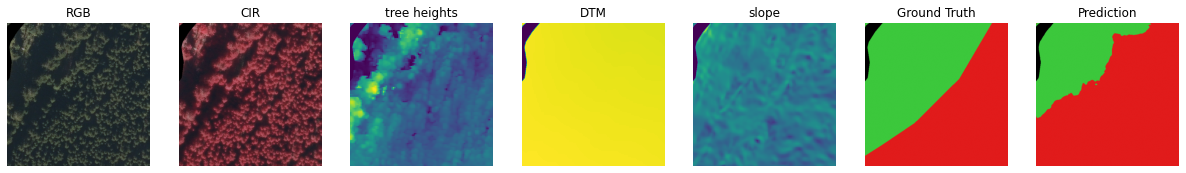

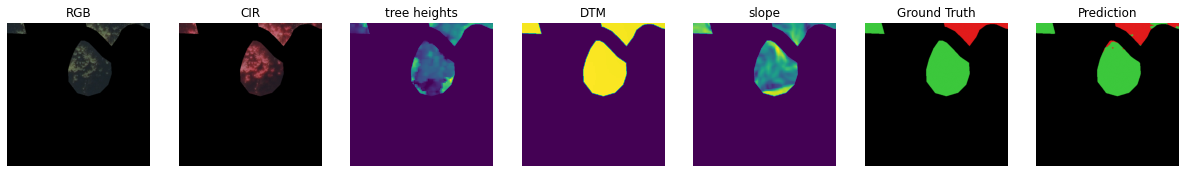

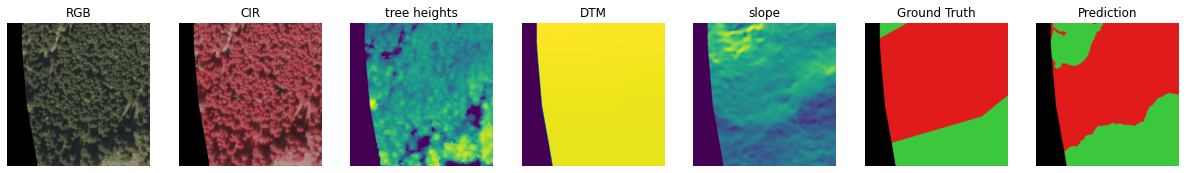

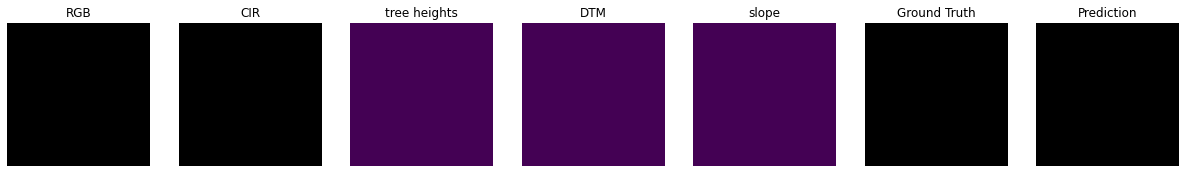

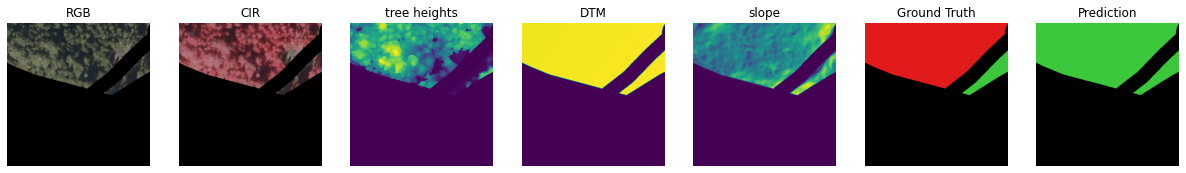

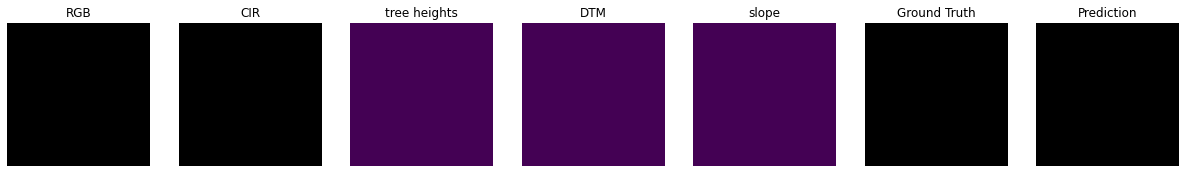

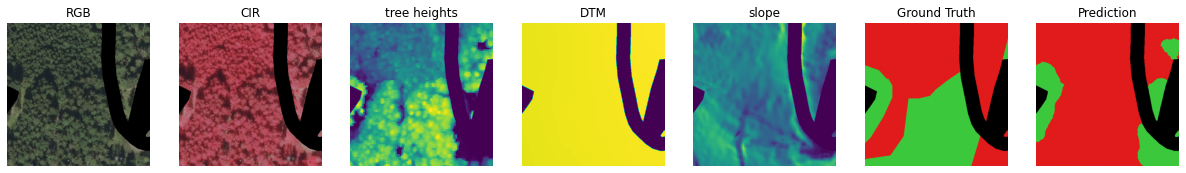

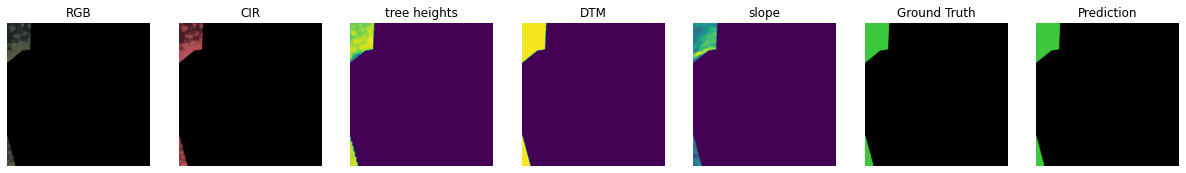

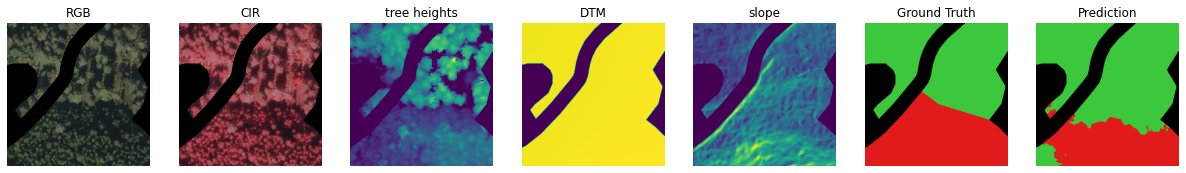

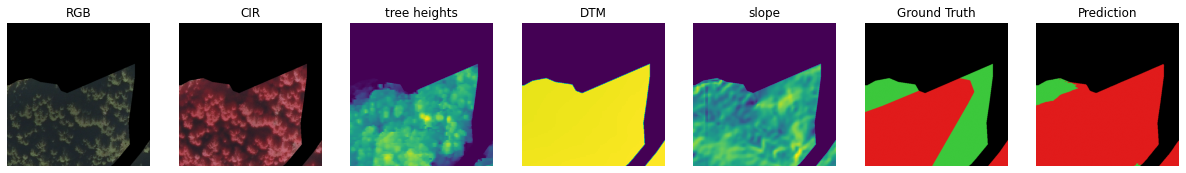

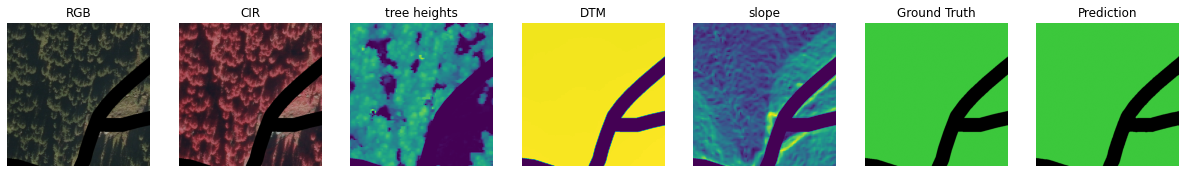

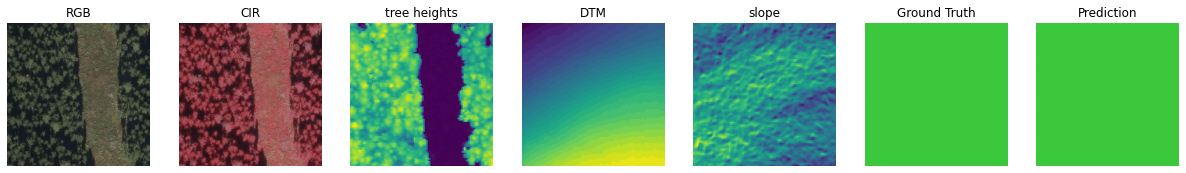

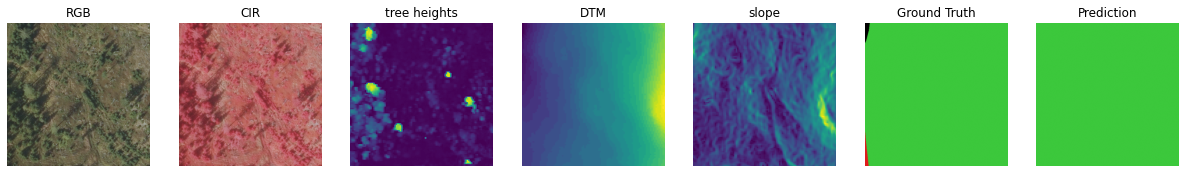

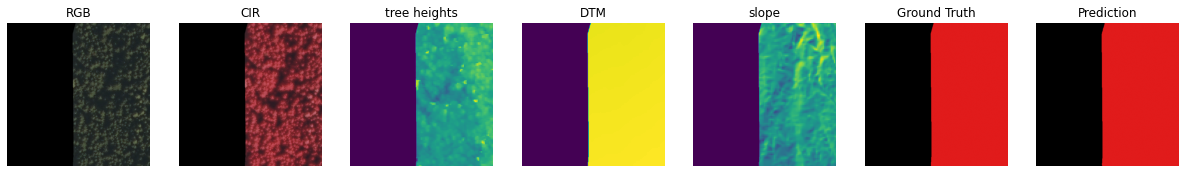

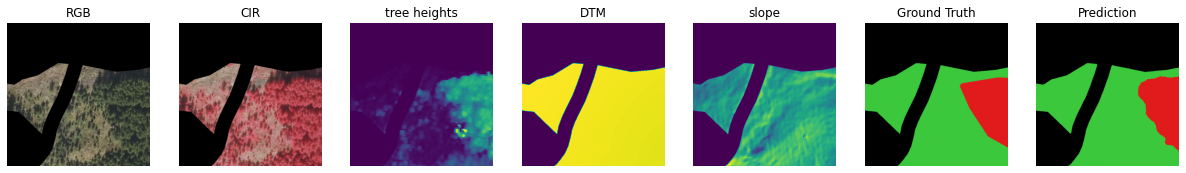

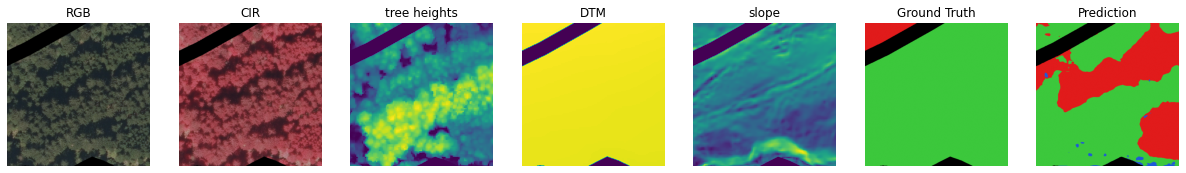

In [15]:
mgr.view_sample_predictions(model, loader=test_dl, n=16, device=device)

In [30]:
#######################################################################################

In [142]:
torch.cuda.empty_cache()

In [143]:
type_dict = {'rgb':'RGB', 'cir':'CIR', 'dsm':'CHM', 'dtm':'DTM', \
             'slope':'Slope', 'gt':'Ground Truth', 'pred':'Prediction'}

In [144]:
def plot_tile(inputs, typ='rgb'):
    
    dict_typ={'dsm':4, 'dtm':5, 'slope':6}
    
    if (typ == 'rgb') or (typ == 'cir'):
        fig, ax = plt.subplots(1,1, figsize=(9,9))
        ax.imshow(img_utils.decode_ortho(inputs[:4], typ))
        ax.set_title(type_dict[typ])
        ax.axis('off')
        
    elif typ in ['dsm', 'dtm', 'slope']:
        fig, ax = plt.subplots(1,1, figsize=(9,9))
        ax.imshow(img_utils.decode_img(inputs[dict_typ[typ]], typ))
        ax.set_title(type_dict[typ])
        ax.axis('off')
    
    elif typ in ['gt', 'pred']:
        fig, ax = plt.subplots(1,1, figsize=(9,9))
        ax.imshow(img_utils.view_annotated(inputs, plot=False))
        ax.set_title(type_dict[typ])
        ax.axis('off')
        

In [145]:
def predict(inputs):
    # load data to device
    data = Variable(inputs.to(device))
    label = Variable(targets.to(device))
    # get predictions
    with torch.no_grad():
        output = model(data)
    pred = mgr.get_predictions(output)
    return pred

In [146]:
idx_test = test_sampler.indices

In [147]:
list_X = []
list_y = []
for i in range(30,60):
    list_X.append(dataset[idx_test[i]][0])
    list_y.append(dataset[idx_test[i]][1])
# create 
inputs = torch.stack(list_X)
targets = torch.stack(list_y)
predictions = predict(inputs)

/home/philipp/.local/lib/python3.8/site-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [155]:
j=0

# load data
inp = inputs[j]
trg = targets[j]
pred = predictions[j]

# clean prediction
pred[pred==0] = 2
pred[pred==3] = 2
pred[trg==0] = 0

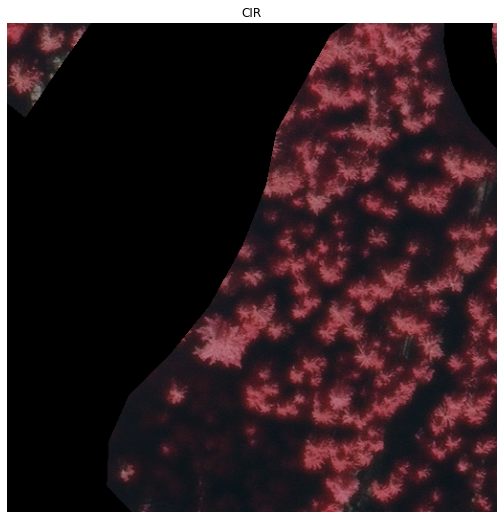

In [156]:
plot_tile(inp, typ='cir')

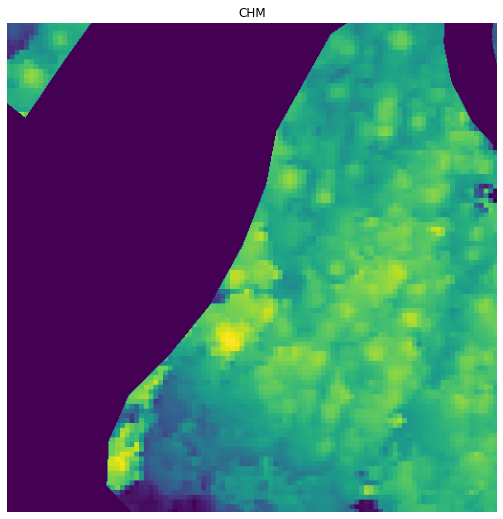

In [157]:
plot_tile(inp, typ='dsm')

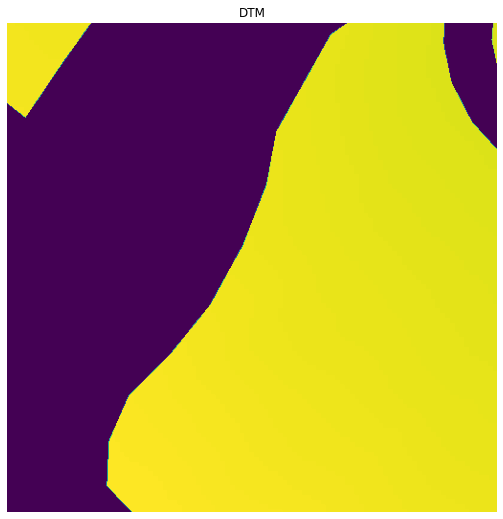

In [158]:
plot_tile(inp, typ='dtm')

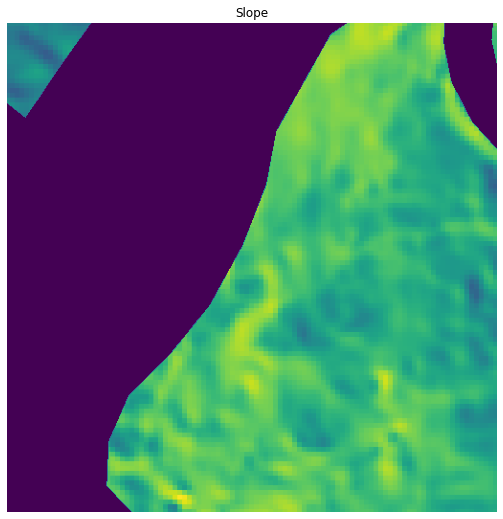

In [159]:
plot_tile(inp, typ='slope')

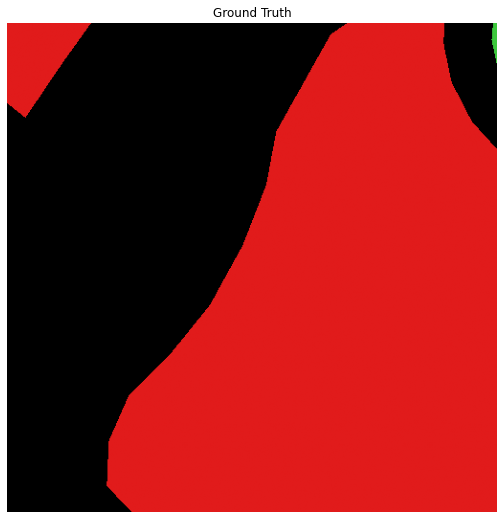

In [160]:
plot_tile(trg, typ='gt')

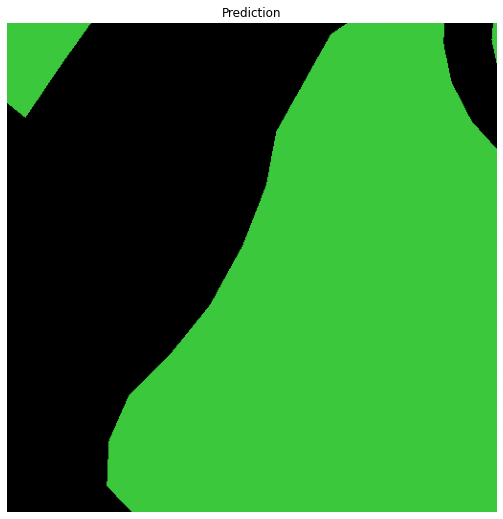

In [161]:
plot_tile(pred, typ='pred')

In [ ]:
#######################################################################################

In [607]:
def get_pixel(j):
    
    data_collector = []
    
    # define mean and std
    means_dsm = np.array([13.45], dtype='float32')
    stds_dsm = np.array([10.386633252098674], dtype='float32')
    
    # load data
    inp = inputs[j]
    trg = targets[j]
    pred = predictions[j]

    # clean prediction
    pred[pred==0] = 2
    pred[trg==0] = 0
    
    # create mask with errors
    mask_pos = trg == pred
    mask_neg = ~mask_pos
    
    for i in range(3):
        
        mask_type = trg == i
        
        for mask_pn in [mask_pos, mask_neg]:
            
            mask = mask_pn * mask_type
            err = inp * mask
            err_dsm = ((err[4][err[4]>0].numpy()) * stds_dsm) + means_dsm
            
            data_collector.append(err_dsm)
    
    return data_collector

In [608]:
dc = get_pixel(19)

In [612]:
len(dc)

6

In [611]:
np.concatenate(dc).shape

(188012,)

In [585]:
j=19

# load data
inp = inputs[j]
trg = targets[j]
pred = predictions[j]

# clean prediction
pred[pred==0] = 2
pred[trg==0] = 0

In [586]:
# create mask with errors
mask = trg == pred
#mask = ~mask
# filter errors
err = inp * mask

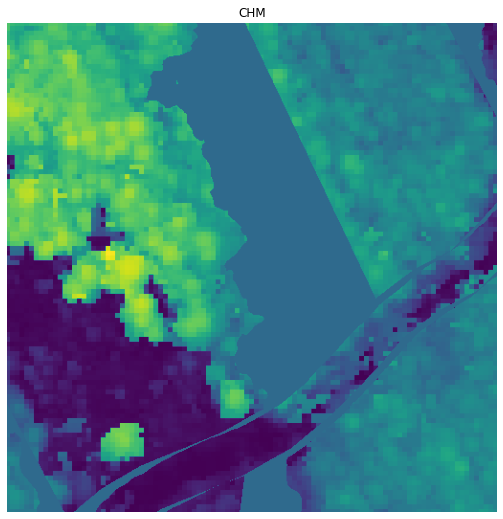

In [587]:
plot_tile(err, typ='dsm')

In [588]:
# define mean and std
means_dsm = np.array([13.45], dtype='float32')
stds_dsm = np.array([10.386633252098674], dtype='float32')

err_dsm = err[4][err[4]>0].numpy()
err_dsm = (err_dsm * stds_dsm) + means_dsm

In [589]:
print(err_dsm.shape)
print(err_dsm)

(147801,)
[28.15625 28.15625 28.15625 ... 18.71875 18.71875 18.71875]


In [581]:
# create mask with errors
mask = targets == predictions
mask = ~mask
# filter errors
err = inputs * mask.unsqueeze(1)

In [582]:
inputs.shape

torch.Size([30, 7, 512, 512])

In [514]:
mask.unsqueeze(1).shape

torch.Size([30, 1, 512, 512])

In [515]:
err.shape

torch.Size([30, 7, 512, 512])

In [524]:
# define mean and std
means_dsm = np.array([13.45], dtype='float32')
stds_dsm = np.array([10.386633252098674], dtype='float32')

# get dsm (layer 4)
#err_dsm = err[:,4].numpy().flatten()#[err[:,4]>0].numpy()
err_dsm = err[:,4][err[:,4]>0].numpy()
# denormalise
err_dsm = (err_dsm * stds_dsm) + means_dsm

In [531]:
# define mean and std
means_ir = np.array([119.50916281232037], dtype='float32')
stds_ir = np.array([49.301477498205074], dtype='float32')

# get dsm (layer 3)
err_ir = err[:,3].numpy().flatten()#[err[:,3]>0].numpy()
#err_ir = err[:,3][err[:,3]>0].numpy()
# denormalise
err_ir = (err_ir * stds_ir) + means_ir

In [533]:
err_ir.shape

(7864320,)

In [583]:
import matplotlib.pyplot as plt

(array([ 6727., 12017., 18611., 18827., 15359., 12083.,  8488.,  6245.,
         5458.,  7385.,  8284.,  7532.,  8035.,  5695.,  3140.,  2200.,
         1040.,   550.,    50.,    75.]),
 array([13.453125, 14.728907, 16.004688, 17.280468, 18.55625 , 19.832031,
        21.107813, 22.383595, 23.659374, 24.935156, 26.210938, 27.48672 ,
        28.7625  , 30.03828 , 31.314062, 32.589844, 33.865623, 35.141407,
        36.417187, 37.69297 , 38.96875 ], dtype=float32),
 <BarContainer object of 20 artists>)

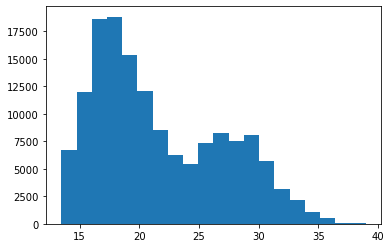

In [590]:
plt.hist(err_dsm, bins=20)

In [ ]:
#######################################################################################

In [90]:
def find_files(dir_img, data_types, sort=False):
    """
    find paths for provided data types
    inputs:
        dir_img (str) : directory path
        data_types (list) : list of data types to be included (exp: ['ortho', 'ground_truth'])
    return:
        paths (dictionary) : dictionary containing file paths for each of the data types
    """

    idxs = []
    # loop over all files found in directory and retrive indices
    for file in os.listdir("{}{}/".format(dir_img, data_types[0])):
        if file[-4:] == ".tif":
            idxs.append(file[file.rfind('_'):])

    if sort:
        idxs = sorted(idxs)

    paths = {}
    for data_type in data_types:
        paths[data_type] = []

    for idx in idxs:

        # check if index in all data types
        check_path = []
        for data_type in data_types:
            p = "{}{}/tile_{}{}".format(dir_img, data_type, data_type, idx)
            if os.path.isfile(p):
                check_path.append(p)

        if len(check_path) == len(data_types):
            for i, data_type in enumerate(data_types):
                paths[data_type].append(check_path[i])

    return paths

In [92]:
import os
find_files('/media/philipp/DATA/2018_tamsweg/', data_types=['ortho', 'dsm', 'dtm', 'slope'], sort=True)

{'ortho': ['/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_121889.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_121890.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122277.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122278.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122279.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122280.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122647.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122648.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122649.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122650.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122651.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122652.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_122653.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_123009.tif',
  '/media/philipp/DATA/2018_tamsweg/ortho/tile_ortho_123010.tif',
 

In [1]:
x=['ortho', 'dsm', 'dtm']

In [3]:
'dtm' in x

True

In [14]:
idx_test = test_sampler.indices